Copyright 2021-2024 Lawrence Livermore National Security, LLC and other MuyGPyS Project Developers. See the top-level COPYRIGHT file for details.

SPDX-License-Identifier: MIT

# Deep Kernels with MuyGPs in PyTorch Tutorial

In this tutorial, we outline how to construct a simple deep kernel model using the PyTorch implementation of MuyGPs.


We use the MNIST classification problem as a benchmark.
We will use the deep kernel MuyGPs model to classify images of handwritten digits between 0 and 9.
In order to reduce the runtime of the training loop, we will use a fully-connected architecture, meaning we will have to vectorize each image prior to training.
We download the training and testing data using the torchvision.datasets API.

In [1]:
import sys
for m in sys.modules.keys():
    if m.startswith("Muy"):
        sys.modules.pop(m)

First, we will import necessary dependencies.
We also force MuyGPyS to use the `"torch"` backend.
This can also be done by setting the `MUYGPYS_BACKEND` environment variable to `"torch"`. 

In [2]:
%env MUYGPYS_BACKEND=torch
%env MUYGPYS_FTYPE=32

env: MUYGPYS_BACKEND=torch
env: MUYGPYS_FTYPE=32


In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import torch
import torchvision
from MuyGPyS.examples.muygps_torch import predict_model
from MuyGPyS.gp import MuyGPS 
from MuyGPyS.gp.deformation import l2, Isotropy
from MuyGPyS.gp.hyperparameter import Parameter
from MuyGPyS.gp.kernels import Matern
from MuyGPyS.gp.noise import HomoscedasticNoise
from MuyGPyS.neighbors import NN_Wrapper
from MuyGPyS.optimize.batch import sample_batch
from MuyGPyS.torch import MuyGPs_layer
from torch import nn
from torch.nn.functional import one_hot
from torch.optim.lr_scheduler import ExponentialLR

I0000 00:00:1707872829.179408       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


We set the target directory for torch to download MNIST.

In [4]:
root = './data'
if not os.path.exists(root):
    os.mkdir(root)

We use torch's utilities to download MNIST and transform it into an appropriately normalized tensor.

In [5]:
trans = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5,),(1.0,)),
    ]
)
train_set = torchvision.datasets.MNIST(
    root=root, train=True, transform=trans, download=True
)
test_set = torchvision.datasets.MNIST(
    root=root, train=False, transform=trans, download=True
)

MNIST is a popular benchmark dataset of hand-written digits, 0-9.
Each digit is a 28x28 pixel image, with 784 total pixel features.

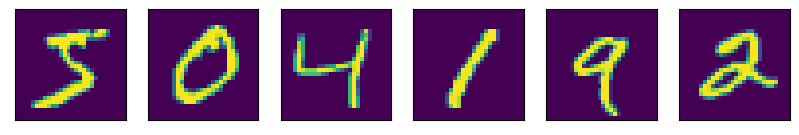

In [6]:
fig, axes = plt.subplots(1, 6, figsize=(10, 3))
for i, ax in enumerate(axes):
    ax.imshow(train_set.data[i, :, :])
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In the interest of reducing the runtime of this example, we will use vectorized images as our features in
this dataset.
We will collect 60,000 training samples and 10,000 test samples.

In [7]:
class_count = len(train_set.classes)
train_count, x_pixel_count, y_pixel_count = train_set.data.shape
test_count, _, _ = test_set.data.shape
feature_count = x_pixel_count * y_pixel_count

We vectorize the images and one-hot encode the class labels.


In [8]:
train_features = torch.zeros((train_count, feature_count))
train_responses = torch.zeros((train_count, class_count))

for i in range(train_count):
    train_features[i,:] = train_set[i][0].flatten()
    train_responses[i,:] = one_hot(
        torch.tensor(train_set[i][1]).to(torch.int64),
        num_classes=class_count,
    )

test_features = torch.zeros((test_count, feature_count))
test_responses = torch.zeros((test_count, class_count))

for i in range(test_count):
    test_features[i,:] = test_set[i][0].flatten()
    test_responses[i,:] = one_hot(
        torch.tensor(test_set[i][1]).to(torch.int64),
        num_classes=class_count,
    )

We set up our nearest neighbor lookup structure using the NN_Wrapper data structure in MuyGPs.
We then define our batch and construct tensor containing the features and targets of the batched elements and their 30 nearest neighbors.
We choose an algorithm that will return the exact nearest neighbors.
We set a random seed for reproducability.

In [9]:
torch.autograd.set_detect_anomaly(True)
np.random.seed(0)
test_count, _ = test_features.shape
train_count, _ = train_features.shape

nn_count = 30
nbrs_lookup = NN_Wrapper(train_features, nn_count, nn_method="exact")

We sample a training batch of 500 elements and record their indices and those of their nearest neighbors.

In [10]:
batch_count = 500
batch_indices, batch_nn_indices = sample_batch(
    nbrs_lookup, batch_count, train_count
)

batch_features = train_features[batch_indices,:]
batch_targets = train_responses[batch_indices, :]
batch_nn_targets = train_responses[batch_nn_indices, :]

if torch.cuda.is_available():
    train_features = train_features.cuda()
    train_responses = train_responses.cuda()
    test_features = test_features.cuda()
    test_responses = test_responses.cuda()

We now define a stochastic variational deep kernel MuyGPs class.
This class composes a dense neural network embedding with a `MuyGPyS.torch.muygps_layer` Gaussian process layer.
Presently, this layer only supports the Matérn kernel with special values of the smoothness parameter set to 0.5, 1.5, 2.5, or $\infty$.
The smoothness values are limited because `torch` does not implement modified bessel functions of the second kind.
Future versions of the library will also support other kernel types.

In [11]:
class SVDKMuyGPs(nn.Module):
    def __init__(
        self,
        muygps_model,
        batch_indices,
        batch_nn_indices,
        batch_targets,
        batch_nn_targets,
    ):
        super().__init__()
        self.embedding = nn.Sequential(
            nn.Linear(784,400),
            nn.ReLU(),
            nn.Linear(400,200),
            nn.ReLU(),
            nn.Linear(200,100),
        )
        self.batch_indices = batch_indices
        self.batch_nn_indices = batch_nn_indices
        self.batch_targets = batch_targets
        self.batch_nn_targets = batch_nn_targets
        self.GP_layer = MuyGPs_layer(
            muygps_model,
            batch_indices,
            batch_nn_indices,
            batch_targets,
            batch_nn_targets,
        )
        self.deformation = self.GP_layer.deformation
    
    def forward(self,x): 
        predictions = self.embedding(x)
        predictions, variances = self.GP_layer(predictions)
        return predictions, variances

## Training a Deep Kernel MuyGPs Model

We will use a Matérn kernel with a smoothness parameter of 0.5 and a Guassian homoscedastic noise prior variance of `1e-6`.

⚠️ Presently the torch backend only supports fixed special case Matérn smoothness parameters with values 0.5, 1.5, or 2.5. ⚠️

⚠️ An isotropic length scale is the only torch-optimizable parameter. ⚠️

In [12]:
muygps_model = MuyGPS(
    kernel=Matern(
        smoothness=Parameter(0.5),
        deformation=Isotropy(
            l2,
            length_scale=Parameter(1.0, (0.1, 2))
        ),
    ),
    noise=HomoscedasticNoise(1e-6),
)

We instantiate a `SVDKMuyGPs` model using this MuyGPS model.

In [13]:
model = SVDKMuyGPs(
    muygps_model = muygps_model,
    batch_indices=batch_indices,
    batch_nn_indices=batch_nn_indices,
    batch_targets=batch_targets,
    batch_nn_targets=batch_nn_targets,
)
if torch.cuda.is_available():
    model = model.cuda()

We use the Adam optimizer over 10 training iterations, with an initial learning rate of `1e-2` and decay of `0.97`.

In [14]:
training_iterations = 10
optimizer = torch.optim.Adam(
    [{'params': model.parameters()}], lr=1e-2
)
scheduler = ExponentialLR(optimizer, gamma=0.97)

We will use cross-entropy loss, as it is commonly performant for classification problems.
Other losses are available.

In [15]:
ce_loss = nn.CrossEntropyLoss()

We construct a standard PyTorch training loop function.

In [16]:
def train(nbrs_lookup):
    for i in range(training_iterations):
        model.train()
        optimizer.zero_grad()
        predictions,variances = model(train_features)
        loss = ce_loss(predictions,batch_targets)
        loss.backward()      
        optimizer.step()
        scheduler.step()
        if np.mod(i,1) == 0:
            print(f"Iter {i + 1}/{training_iterations} - Loss: {loss.item()}")
            model.eval()
            nbrs_lookup = NN_Wrapper(
                model.embedding(train_features).detach().numpy(), 
                nn_count, nn_method="exact"
            )
            batch_nn_indices,_ = nbrs_lookup._get_nns(
                model.embedding(batch_features).detach().numpy(),
                nn_count=nn_count,
            )
            batch_nn_targets = train_responses[batch_nn_indices, :]  
            model.batch_nn_indices = batch_nn_indices
            model.batch_nn_targets = batch_nn_targets
        torch.cuda.empty_cache()
    nbrs_lookup = NN_Wrapper(
        model.embedding(train_features).detach().numpy(),
        nn_count,
        nn_method="exact",
    )
    batch_nn_indices,_ = nbrs_lookup._get_nns(
        model.embedding(batch_features).detach().numpy(),
        nn_count=nn_count,
    )
    batch_nn_targets = train_responses[batch_nn_indices, :]
    model.batch_nn_indices = batch_nn_indices
    model.batch_nn_targets = batch_nn_targets
    return nbrs_lookup, model

Finally, we execute the training function and evaluate the trained model

In [17]:
nbrs_lookup, model_trained = train(nbrs_lookup)

Iter 1/10 - Loss: 1.514917016029358
Iter 2/10 - Loss: 1.4779890775680542
Iter 3/10 - Loss: 1.4398393630981445
Iter 4/10 - Loss: 1.423111081123352
Iter 5/10 - Loss: 1.4219379425048828
Iter 6/10 - Loss: 1.4020675420761108
Iter 7/10 - Loss: 1.3868385553359985
Iter 8/10 - Loss: 1.3743661642074585
Iter 9/10 - Loss: 1.3675148487091064
Iter 10/10 - Loss: 1.3568177223205566


Our final model parameters look like the following:

In [18]:
for n, p in model_trained.named_parameters():
    print(f"{n}, {p.shape if p.shape != torch.Size([]) else p.item()}") 

embedding.0.weight, torch.Size([400, 784])
embedding.0.bias, torch.Size([400])
embedding.2.weight, torch.Size([200, 400])
embedding.2.bias, torch.Size([200])
embedding.4.weight, torch.Size([100, 200])
embedding.4.bias, torch.Size([100])
GP_layer.length_scale, 1.0085885524749756


We then compute and report the performance of the predicted test responses using this trained model.

In [19]:
predictions, variances = predict_model(
    model=model_trained,
    test_features=test_features,
    train_features=train_features,
    train_responses=train_responses,
    nbrs_lookup=nbrs_lookup,
    nn_count=nn_count,
)
print("MNIST Prediction Accuracy Using Hybrid Torch Model:")
print(
    (
        torch.sum(
            torch.argmax(predictions,dim=1) == torch.argmax(test_responses,dim=1)
        ) / 10000
    ).numpy()
)

MNIST Prediction Accuracy Using Hybrid Torch Model:
0.9361


We note that this is quite mediocre performance on MNIST. In the interest of reducing notebook runtime we have used a simple fully-connected neural network model to construct the Gaussian process kernel. To achieve results closer to the state-of-the-art (near 100% accuracy), we recommend using more complex architectures which integrate convolutional kernels into the model.